In [334]:
############################# IMPORT STATEMENTS ########################################################
#Import Python modules
import numpy as np
from matplotlib import pyplot as plt
from mtcnn.mtcnn import MTCNN
from numpy import asarray
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import cv2
import os
import json
import time
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from keras.callbacks import ModelCheckpoint, EarlyStopping

#For local CPU usage:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

#Import Keras modules
from keras.layers import Dense, Flatten, Input, Dropout, Conv1D, Conv2D, LSTM, Concatenate, Reshape, MaxPool1D, MaxPool2D, BatchNormalization
from keras import Model, Sequential
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import tensorflow as tf
from scipy import stats

import dlib
from imutils import face_utils 

In [335]:
############################# SETUP PROJECT PARAMETERS ########################################################
LOAD_PROGRESS_FROM_MODEL = False
SAVE_PROGRESS_TO_MODEL = True

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

PATH_TO_FOLDER = 'C:/Users/Tobias/Desktop/Master-Thesis/Data/AFEW-VA/576'
PATH_TO_DATA = 'C:/Users/Tobias/Desktop/Master-Thesis/Data/AFEW-VA'
FOLDER = "/576"
DATA_DIR_PREDICT = 'C:/Users/Tobias/Desktop/Master-Thesis/Data/facesdb/s005/tif/training/'
DISPLAY_IMG_NAME = '00000.png'
IMG_FORMAT = '.png'

batch_size = 32
num_folds = 3   # needs to be at least 2 for train and test

CROSS_VALIDATION = False
EPOCHS = 20
EPOCHS_CROSS = 10

# Approach:

### 1. Face detection
using MTCNN (Simultaneous face detection, face alignment, bounding boxing and landmark detection)

### 2. Highlighting faces
draw the bounding box in an image and plot it - to check out the result

### 3. Face extraction
extracting the face according to the identified bounding box

### 4. Face recognition
Using the VGGFace pretrained Resnet50 model to recognize emotions (training + prediction)

## 0. Get data

In [336]:
# for now reading the RGB values of the image (maybe in future just gray-scale)
def get_image_from_filename(path_to_folder, filename):
    image = cv2.cvtColor(cv2.imread(os.path.join(path_to_folder, filename)), cv2.COLOR_BGR2RGB)
    return image

def get_image_from_filename_GRAY(path_to_folder, filename):
    image = cv2.cvtColor(cv2.imread(os.path.join(path_to_folder, filename)), cv2.COLOR_BGR2GRAY)
    return image

def get_all_images(path_to_data):
    images = []
    for folder in os.listdir(path_to_data):
        for filename in os.listdir(os.path.join(path_to_data, folder)):
            img = cv2.imread(os.path.join(path_to_data, folder, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
    return images

def get_all_images_GRAY(path_to_data):
    images = []
    for folder in os.listdir(path_to_data):
        for filename in os.listdir(os.path.join(path_to_data, folder)):
            img = cv2.imread(os.path.join(path_to_data, folder, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                images.append(img)
    return images

In [337]:
# sructure data according to emotions (necessary to read in labels)
def get_labels(path_to_data):
    labels = []
    
    for folder in os.listdir(path_to_data):
        with open(os.path.join(path_to_data, folder, folder + ".json")) as p:
            data = json.load(p)
        frames = data['frames']
    
        for key, value in frames.items():
            labels.append([value['valence'], value['arousal']])

    return labels

def get_labels_from_folder(path_to_data, folder):
    labels = []
    
    with open(os.path.join(path_to_data, folder, folder + ".json")) as p:
        data = json.load(p)
    frames = data['frames']

    for key, value in frames.items():
        labels.append([value['valence'], value['arousal']])

    return labels

In [338]:
# split data into training, cv and test
def get_splitted_data(path_to_data):
    labels = get_labels(path_to_data)
    filenames = get_all_images(path_to_data)
    
    filenames_shuffled_np, labels_shuffled_np = shuffle(filenames, labels)
    X_training, X_test, Y_training, Y_test = train_test_split(filenames_shuffled_np, labels_shuffled_np, test_size=0.2, random_state=1)
    
    return X_training, X_test, Y_training, Y_test

 
## 1. Face detection

In [339]:
detector = MTCNN()

def detect_face(image):
    face = detector.detect_faces(image)
    return face

def detect_faces(images):
    faces = []  
    for img in images:
        face = detector.detect_faces(img)
        if len(face) == 1:
            faces.append(face)  ## just use the face with the highest detection probability
        elif len(face) > 1:
            faces.append(face[0])
        else:
            faces.append([]) ### no face was detected
    return faces

In [340]:
image = get_image_from_filename(PATH_TO_FOLDER, DISPLAY_IMG_NAME)
face = detect_face(image)
print(face)
len(face)

[{'box': [282, 71, 157, 245], 'confidence': 0.9993501305580139, 'keypoints': {'left_eye': (318, 160), 'right_eye': (392, 171), 'nose': (333, 212), 'mouth_left': (315, 251), 'mouth_right': (372, 261)}}]


1

## 2. Higlighting face

In [341]:
def highlight_face(path_to_folder, filename):
  # display image
    image = get_image_from_filename(path_to_folder, filename)
    plt.imshow(image)

    ax = plt.gca()
    face = detect_face(image)
    
    # for each face in the image, draw a rectangle based on coordinates
    elem = face[0]
    x, y, width, height = elem['box']
    print(x)
    print(y)
    print(width)
    print(height)
    face_border = Rectangle((x, y), width, height,
                      fill=False, color='red')
    ax.add_patch(face_border)
    #plt.show()

282
71
157
245
Label: 
[-5.0, 3.0]


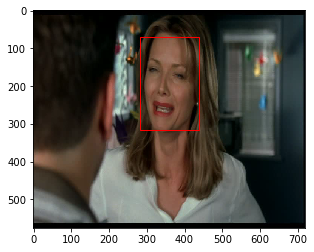

In [342]:
highlight_face(PATH_TO_FOLDER, "00000.png")
labels = get_labels_from_folder(PATH_TO_DATA, "576")
print("Label: ")
print(labels[0])

In [343]:
p = "shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(p) 

def highlight_landmarks(path_to_folder, filename):
    image = get_image_from_filename(path_to_folder, filename)
    #plt.imshow(image)

    ax = plt.gca()
    face = detect_face(image)
    
    elem = face[0]
    x, y, width, height = elem['box']
    print(elem['box'])
    face_border = Rectangle((x, y), width, height,
                      fill=False, color='red')
    ax.add_patch(face_border)
    
    rect = dlib.rectangle(left=x, top=y, right=(x+width), bottom=(y+height))
    print(rect)
    landmarks = predictor(image, rect)
    landmarks_list = []
    
    for n in range(0,68):
        x=landmarks.part(n).x
        y=landmarks.part(n).y
        cv2.circle(image, (x, y), 4, (0, 0, 255), -1)
        landmarks_list.append([x, y])
    
    landmarks_list = np.array(landmarks_list)
    landmarks_flatten = landmarks_list.flatten()
    print(landmarks_flatten)
    print(landmarks_list.shape)
    print(landmarks_flatten.shape)
    
    plt.imshow(image)

[282, 71, 157, 245]
[(282, 71) (439, 316)]
[300 159 297 183 295 206 295 230 298 254 303 277 310 298 318 317 331 326
 348 327 368 320 388 310 407 294 420 272 428 244 433 215 438 185 303 133
 311 126 320 127 330 133 339 142 365 146 378 143 391 143 403 147 413 157
 348 164 345 178 341 193 337 208 329 219 334 223 339 227 346 226 354 226
 312 159 319 157 326 159 332 165 324 165 317 163 373 173 381 170 389 172
 396 178 388 179 380 177 316 250 322 242 331 241 339 246 348 245 361 248
 374 261 360 279 346 285 337 284 328 281 320 271 320 252 330 251 339 254
 348 254 370 262 347 272 338 271 329 267]
(68, 2)
(136,)


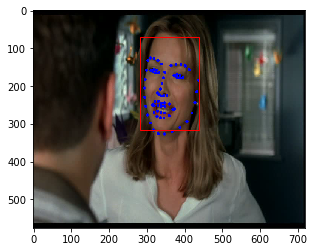

In [344]:
highlight_landmarks(PATH_TO_FOLDER, DISPLAY_IMG_NAME)

## 3. Face extraction

In [345]:
def extract_face_from_image(image, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    face = detect_face(image) # content of face is a python dict

    # extract the bounding box from the requested face
    box = np.asarray(face[0]['box'])
    box[box < 0] = 0
    x1, y1, width, height =  box
    
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face_boundary = image[y1:y2, x1:x2]

    # resize pixels to the model size
    face_image = Image.fromarray(face_boundary)
    face_image = face_image.resize(required_size)
    face_array = asarray(face_image)
        
    return face_array


def extract_face_from_images(images, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    faces = detect_faces(images)
    face_images = []
    
    for i in range(len(images)):
        if faces[i-1] == []: # No face detected
            face_image = Image.fromarray(images[i-1])
            face_image = face_image.resize(required_size)
            face_array = asarray(face_image)
            face_images.append(face_array)
        else:
            # extract the bounding box from the requested face
            if type(faces[i-1]) is list:  # checks whether more than one face was detected
                box = np.asarray(faces[i-1][0]['box'])
                box[box < 0] = 0
                x1, y1, width, height = box
            else:
                box = np.asarray(faces[i-1]['box'])
                box[box < 0] = 0
                x1, y1, width, height = box

            x2, y2 = x1 + width, y1 + height
            # extract the face
            face_boundary = images[i-1][y1:y2, x1:x2]

            # resize pixels to the model size
            face_image = Image.fromarray(face_boundary)
            face_image = face_image.resize(required_size)
            face_array = asarray(face_image)
            face_images.append(face_array)
            
    return face_images

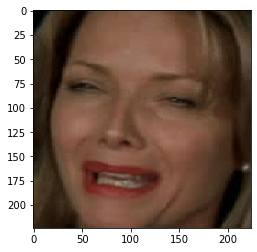

(224, 224, 3)

In [346]:
# Display the first face from the extracted faces
image = get_image_from_filename(PATH_TO_FOLDER, DISPLAY_IMG_NAME)
extracted_face = extract_face_from_image(image)
plt.imshow(extracted_face)
plt.show()
extracted_face.shape

## 4. Face recognition -> Emotions

In [347]:
def get_face_embedding(faces):
    samples = asarray(faces, 'float32')

    # prepare the data for the model
    samples = preprocess_input(samples, version=2)

    # create a vggface model object
    model = VGGFace(model='resnet50',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg')
    
    # perform prediction
    return model.predict(samples)

In [348]:
X_training, X_test, Y_train, Y_test = get_splitted_data(PATH_TO_DATA)

In [349]:
print(len(X_training))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

96
25
96
25


In [350]:
X_train_faces = extract_face_from_images(X_training)
X_test_faces = extract_face_from_images(X_test)

X_train_embeddings = get_face_embedding(X_train_faces)
X_test_embeddings = get_face_embedding(X_test_faces)

In [351]:
np.savetxt('X_train_embeddings.txt', X_train_embeddings)
np.savetxt('X_test_embeddings.txt', X_test_embeddings)

np.savetxt('Y_train.txt', Y_train)
np.savetxt('Y_test.txt', Y_test)

In [352]:
X_train_embeddings = np.loadtxt('X_train_embeddings.txt')
X_test_embeddings = np.loadtxt('X_test_embeddings.txt')

Y_train = np.loadtxt('Y_train.txt')
Y_test = np.loadtxt('Y_test.txt')

In [353]:
#the model returns a vector, which represents the features of a face
print(X_train_embeddings)
print(X_train_embeddings.shape)
Y_train = np.asarray(Y_train)

[[0.52709341 0.         0.         ... 1.33193517 0.31531858 0.        ]
 [0.21421218 0.         3.81438804 ... 0.67631412 1.40397358 4.83799362]
 [0.         0.         0.95799595 ... 0.19151232 0.         0.80296993]
 ...
 [0.         1.62315285 1.61211967 ... 7.13565445 1.88571489 7.98704433]
 [0.         0.         4.02632952 ... 0.80598086 1.97880721 4.6465621 ]
 [0.21901929 0.         0.08308016 ... 0.         0.         0.        ]]
(96, 2048)


In [354]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [355]:
def corr(y_true, y_pred):
    #normalise
    n_y_true = (y_true - K.mean(y_true[:])) / K.std(y_true[:])
    n_y_pred = (y_pred - K.mean(y_pred[:])) / K.std(y_pred[:])  

    top=K.sum((n_y_true[:]-K.mean(n_y_true[:]))*(n_y_pred[:]-K.mean(n_y_pred[:])),axis=[-1,-2])
    bottom=K.sqrt(K.sum(K.pow((n_y_true[:]-K.mean(n_y_true[:])),2),axis=[-1,-2])*K.sum(K.pow(n_y_pred[:]-K.mean(n_y_pred[:]),2),axis=[-1,-2]))

    result=top/bottom
    return K.mean(result)

In [356]:
def corr_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)



In [357]:
def model_top(input_shape):
    model_input = Input(shape = (input_shape,))
    x = Dense(256, activation='relu')(model_input)
    x = Dropout(0.3)(model_input)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    out1 = Dense(21, activation='softmax', name='out1')(x)
    out2 = Dense(21, activation='softmax', name='out2')(x)

    model = Model(inputs=model_input , outputs= [out1, out2])
    return model

In [358]:
def one_hot_encoding(input_array):
    values = np.array([-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    # integer encode
    label_encoder = LabelEncoder()
    label_encoder.fit(values)
    values_enc = label_encoder.transform(values)
    input_array_encoding = label_encoder.transform(input_array)

    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    values_enc = values_enc.reshape(len(values_enc), 1)
    onehot_encoder.fit(values_enc)
    input_array_reshape = input_array_encoding.reshape(len(input_array_encoding), 1)
    input_array_onehot = onehot_encoder.transform(input_array_reshape)
    return input_array_onehot


def one_hot_undo(one_hot_encoded):
    values = np.array([-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    label_encoder = LabelEncoder()
    label_encoder.fit(values)
    inverted = label_encoder.inverse_transform([argmax(one_hot_encoded)])
    return inverted

In [359]:
# Change labes to one-hot encoding
Y_tr = Y_train
Y_te = Y_test

Y_train_V = one_hot_encoding(Y_train[:,0])
Y_train_A = one_hot_encoding(Y_train[:,1])
Y_test_V = one_hot_encoding(Y_test[:,0])
Y_test_A = one_hot_encoding(Y_test[:,1])

In [360]:
Y_train = np.zeros((len(Y_train_V), 2, len(Y_train_V[0])))
for i in range(0, len(Y_train_V)):
    Y_train[i] = [Y_train_V[i], Y_train_A[i]]
    
Y_test = np.zeros((len(Y_test_V), 2, len(Y_test_V[0])))
for i in range(0, len(Y_test_V)):
    Y_test[i] = [Y_test_V[i], Y_test_A[i]]

print(Y_train.shape)
print(Y_test.shape)

(96, 2, 21)
(25, 2, 21)


In [369]:
print(Y_tr[1])
print(Y_train[1])
print(one_hot_undo(Y_train[1][1]))

[-8.  3.]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[3]


In [323]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

inputs = np.concatenate((X_train_embeddings, X_test_embeddings), axis=0)
targets = np.append(Y_train, Y_test, axis = 0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [361]:
inputs.shape

(121, 2048)

In [362]:
mc_best = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
mc_es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) # waiting for 10 consecutive epochs that don't reduce the val_loss

In [363]:
# K-fold Cross Validation model evaluation
history_accuracy = []
history_val_accuracy = []
history_loss = []
history_val_loss = []
history_corr = []
history_val_corr = []
history_rmse = []
history_val_rmse = []


if CROSS_VALIDATION == True:
    for train, test in kfold.split(inputs, targets):
        model = model_top(2048)

        if LOAD_PROGRESS_FROM_MODEL:
            model.load_weights("model_checkpoints/model_top.h5")
            print("Loaded model from disk")

        model.summary()
        model.compile(loss = corr_loss, optimizer = "adam", metrics = ["accuracy", rmse, corr])

        # train model  
        scores = model.fit(inputs[train], targets[train], steps_per_epoch = int(len(train) // batch_size), 
                           epochs=EPOCHS_CROSS, verbose=1, validation_data = (inputs[test], targets[test]),
                           validation_steps = int(len(test) // batch_size), callbacks = [mc_best, mc_es])

        history_accuracy.extend(scores.history['accuracy'])
        history_val_accuracy.extend(scores.history['val_accuracy'])
        history_loss.extend(scores.history['loss'])
        history_val_loss.extend(scores.history['val_loss'])
        history_corr.extend(scores.history['corr'])
        history_val_corr.extend(scores.history['val_corr'])
        history_rmse.extend(scores.history['rmse'])
        history_val_rmse.extend(scores.history['val_rmse'])
else:
    model = model_top(2048)

    if LOAD_PROGRESS_FROM_MODEL:
        model.load_weights("model_checkpoints/model_top.h5")
        print("Loaded model from disk")

    model.summary()
    opt = SGD(lr=0.01)  # optimizer = "adam"
    model.compile(loss = corr_loss, optimizer = opt, metrics = ["accuracy", rmse, corr])

    # train model  
    scores = model.fit(X_train_embeddings, [Y_train[:,0], Y_train[:,1]], epochs=EPOCHS, verbose=1, validation_data = (X_test_embeddings, [Y_test[:,0], Y_test[:,1]]), callbacks = [mc_best, mc_es])
        # steps_per_epoch = int(len(X_train_embeddings) // batch_size)
        # validation_steps = int(len(X_test_embeddings) // batch_size)

    history_accuracy.extend(scores.history['out1_accuracy'])
    history_val_accuracy.extend(scores.history['val_out1_accuracy'])
    history_loss.extend(scores.history['out1_loss'])
    history_val_loss.extend(scores.history['val_out1_loss'])
    history_corr.extend(scores.history['out1_corr'])
    history_val_corr.extend(scores.history['val_out1_corr'])
    history_rmse.extend(scores.history['out1_rmse'])
    history_val_rmse.extend(scores.history['val_out1_rmse'])

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 2048)         0           input_45[0][0]                   
__________________________________________________________________________________________________
dense_103 (Dense)               (None, 128)          262272      dropout_12[0][0]                 
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 128)          512         dense_103[0][0]                  
___________________________________________________________________________________________

96/96 [==============================] - 0s 1ms/step - loss: 1.9620 - out1_loss: 0.9997 - out2_loss: 0.9623 - out1_accuracy: 0.0312 - out1_rmse: 0.2219 - out1_corr: -0.0035 - out2_accuracy: 0.1667 - out2_rmse: 0.2094 - out2_corr: 0.1901 - val_loss: 1.9723 - val_out1_loss: 0.9996 - val_out2_loss: 0.9727 - val_out1_accuracy: 0.0000e+00 - val_out1_rmse: 0.2313 - val_out1_corr: -0.0188 - val_out2_accuracy: 0.1600 - val_out2_rmse: 0.2117 - val_out2_corr: 0.1653

Epoch 00012: val_loss improved from 1.97678 to 1.97232, saving model to best_model.h5
Epoch 13/20
96/96 [==============================] - 0s 1ms/step - loss: 1.9555 - out1_loss: 0.9987 - out2_loss: 0.9568 - out1_accuracy: 0.0625 - out1_rmse: 0.2197 - out1_corr: 0.0220 - out2_accuracy: 0.1667 - out2_rmse: 0.2088 - out2_corr: 0.1964 - val_loss: 1.9637 - val_out1_loss: 0.9997 - val_out2_loss: 0.9640 - val_out1_accuracy: 0.0000e+00 - val_out1_rmse: 0.2310 - val_out1_corr: -0.0183 - val_out2_accuracy: 0.2000 - val_out2_rmse: 0.2103 - va

In [295]:
if SAVE_PROGRESS_TO_MODEL:
    model.save_weights("model_checkpoints/model_top.h5")
    print("Saved model to disk")

Saved model to disk


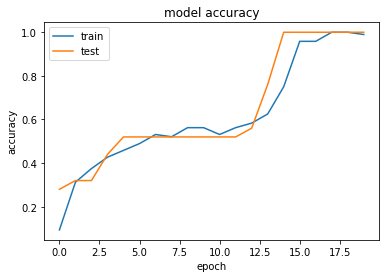

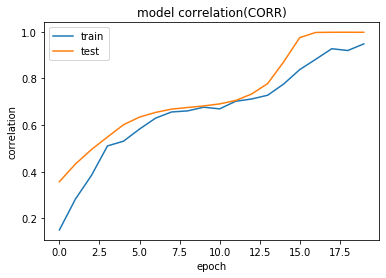

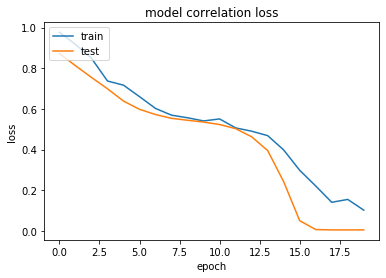

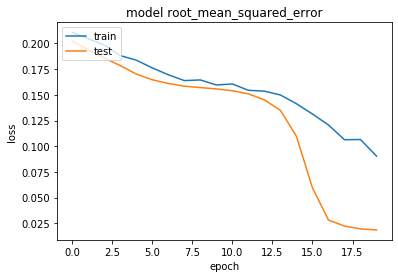

In [296]:
# summarize history for accuracy
plt.figure(1)
plt.plot(history_accuracy)
plt.plot(history_val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_checkpoints/accuracy.png')
plt.show()

# summarize history for CORR
plt.figure(2)
plt.plot(history_corr)
plt.plot(history_val_corr)
plt.title('model correlation(CORR)')
plt.ylabel('correlation')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_checkpoints/correlation.png')
plt.show()

# summarize history for loss
plt.figure(3)
plt.plot(history_loss)
plt.plot(history_val_loss)
plt.title('model correlation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_checkpoints/correlation_loss.png')
plt.show()

# summarize history for RMSE
plt.figure(4)
plt.plot(history_rmse)
plt.plot(history_val_rmse)
plt.title('model root_mean_squared_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_checkpoints/rmse.png')
plt.show()

### PREDICTION

In [304]:
emotion_scores = model.predict(X_test_embeddings)
emotion_scores = np.array(emotion_scores)
print(emotion_scores[0][0])

result = []
for elem in emotion_scores[0]:
    res = one_hot_undo(elem)
    result.append(res)

[2.9434494e-03 1.4428470e-03 5.7877768e-03 2.9909957e-02 2.9404545e-03
 8.6330734e-03 4.7052451e-04 3.7260852e-03 1.0353820e-02 8.6575310e-04
 8.2408559e-01 3.4805404e-03 6.7495822e-04 4.1760788e-03 2.2441647e-03
 2.0792346e-02 3.3156082e-02 3.0990804e-03 3.0277884e-03 2.3822544e-02
 1.4367128e-02]
[1.1759059e-03 7.2291360e-04 4.5698760e-03 1.6332356e-02 2.8591759e-03
 3.8469611e-03 1.7225416e-04 1.3842793e-03 2.7760675e-03 2.8636088e-04
 8.9211196e-01 1.1859247e-03 4.5058966e-04 1.8398914e-03 8.5259072e-04
 7.7933474e-03 1.7062388e-02 1.7719738e-03 1.2072903e-03 3.6391813e-02
 5.2061370e-03]
10
[0]
[3.2003670e-06 5.5544928e-04 1.0654718e-04 6.1419129e-04 1.3543779e-04
 1.7086898e-04 2.8524330e-04 1.8102849e-04 8.0769812e-04 1.5368233e-04
 9.6992254e-01 4.9231810e-05 1.3539955e-03 1.1471623e-02 2.0892196e-03
 3.3640835e-04 3.4438027e-04 2.6761880e-04 2.9008677e-03 1.1405762e-03
 7.1100658e-03]
10
[0]
[2.9434494e-03 1.4428470e-03 5.7877768e-03 2.9909957e-02 2.9404545e-03
 8.6330734e-03 

## TESTING OF PREDICTION + INTEREST IDENTIFICATION

In [36]:
LAYERS_TRAINABLE = False

def custom_vgg_model():
    vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))
    
    for layer in vgg_model.layers: 
        layer.trainable = LAYERS_TRAINABLE
        print(layer.name)
    
    last_layer = vgg_model.get_layer('pool5').output    
    x = Flatten(name='flatten')(last_layer)
    # x = Dense(512, activation='relu')(x)
    # x = Dense(256, activation='relu')(x)
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    out1 = Dense(1, activation='tanh', name='out1')(x)
    out2 = Dense(1, activation='tanh', name='out2')(x)
    custom_vgg_model = Model(inputs= vgg_model.input, outputs= [out1, out2])
    
    return custom_vgg_model

In [37]:
model = custom_vgg_model()
model.load_weights("model_checkpoints/model_best.h5")

input_6
conv1_1
conv1_2
pool1
conv2_1
conv2_2
pool2
conv3_1
conv3_2
conv3_3
pool3
conv4_1
conv4_2
conv4_3
pool4
conv5_1
conv5_2
conv5_3
pool5


ValueError: You are trying to load a weight file containing 110 layers into a model with 18 layers.

In [38]:
input_predict = np.array(X_test_faces)
print(input_predict.shape)

emotion_scores = model.predict(input_predict)

(20, 224, 224, 3)


In [39]:
print(emotion_scores)

[array([[ 0.801178  ],
       [-0.5278205 ],
       [ 0.94960105],
       [ 0.48096284],
       [-0.61118746],
       [ 0.50314844],
       [-0.99963284],
       [-0.99999094],
       [ 0.25405675],
       [ 0.0126596 ],
       [-0.9999985 ],
       [-0.99999344],
       [ 0.43402338],
       [ 0.9814458 ],
       [ 0.40100223],
       [ 0.65627736],
       [ 0.03169425],
       [-0.97280073],
       [-0.9999922 ],
       [-0.09710373]], dtype=float32), array([[ 0.9980449 ],
       [ 0.91676235],
       [ 0.99984986],
       [ 0.5345191 ],
       [-0.9947428 ],
       [ 0.99386054],
       [ 0.48434266],
       [-0.866132  ],
       [ 0.06367462],
       [ 0.02705392],
       [-0.82023674],
       [-0.7216446 ],
       [ 0.816871  ],
       [ 0.99571455],
       [ 0.937302  ],
       [-0.9998329 ],
       [ 0.479341  ],
       [-0.9999269 ],
       [-0.7904573 ],
       [ 0.634019  ]], dtype=float32)]


In [40]:
THRESHOLD = 0.5  # range is from -1 to +1

POSITIVE = 0
NEGATIVE = 0
NEUTRAL = 0

for i in emotion_scores[0]:
    if i > (THRESHOLD/2):
        POSITIVE = POSITIVE + 1
    elif i < (-THRESHOLD/2):
        NEGATIVE = NEGATIVE + 1
    else:
        NEUTRAL = NEUTRAL + 1

print(POSITIVE)
print(NEGATIVE)
print(NEUTRAL)

if NEUTRAL > (POSITIVE + NEGATIVE):
    print("-")
elif POSITIVE/2 > NEGATIVE:
    print("VERY INTERESTED")
elif POSITIVE > NEGATIVE:
    print("INTERESTED")
else:
    print("Not interested!")

9
8
3
INTERESTED


In [42]:
images = get_all_images(PATH_TO_DATA)
images = np.array(images)
print(images.shape)

images_list = []
for image in images:
    face_image = Image.fromarray(image)
    face_image = face_image.resize((224,224))
    face_array = asarray(face_image)      
    images_list.append(face_array)
np_images = np.array(images_list)

(100, 576, 720, 3)


In [44]:
labels = get_labels(PATH_TO_DATA)
labels = np.array(labels)
labels = np.true_divide(labels, 5)
print(labels.shape)

(100, 2)


In [45]:
X_training, X_test, Y_training, Y_test = train_test_split(np_images, labels, test_size=0.2, random_state=0)
print(X_training.shape)
print(X_test.shape)
print(Y_training.shape)
print(Y_test.shape)

(80, 224, 224, 3)
(20, 224, 224, 3)
(80, 2)
(20, 2)


In [46]:
datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    #rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2)
    #horizontal_flip=True)
    #brightness_range=[0.8, 1.0])
    # zoom_range=0.1)

In [47]:
def multi_out(gen):
    for x, y in gen:
        yield x, [y, y]
        
cb_bestModel = ModelCheckpoint('model_checkpoints/model_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [48]:
datagen.fit(X_training)
i = 0
for batch in datagen.flow(X_training, Y_training, batch_size=32, save_to_dir='datagen_preview', save_prefix='gen', save_format='jpeg'):
    print(batch[1])
    i += 1
    if i > 0:
        break

[[5. 4.]
 [2. 5.]
 [4. 4.]
 [2. 4.]
 [3. 5.]
 [0. 5.]
 [2. 3.]
 [0. 5.]
 [4. 4.]
 [3. 5.]
 [0. 5.]
 [0. 5.]
 [4. 3.]
 [2. 4.]
 [5. 4.]
 [5. 4.]
 [4. 3.]
 [5. 4.]
 [2. 3.]
 [4. 4.]
 [5. 4.]
 [0. 5.]
 [0. 5.]
 [4. 3.]
 [2. 4.]
 [0. 5.]
 [0. 5.]
 [3. 4.]
 [3. 5.]
 [4. 3.]
 [0. 5.]
 [0. 5.]]


In [49]:
datagen.fit(X_training)
gen1 = datagen.flow(X_training, Y_training, batch_size=32)
train_steps = len(gen1)
train = multi_out(gen1)

In [50]:
def custom_vgg_model(is_trainable):
    sess2 = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()
    tf.compat.v1.keras.backend.set_session(sess2)

    model_VGGFace = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

    for layer in model_VGGFace.layers:
        layer.trainable = is_trainable

    last_layer = model_VGGFace.get_layer('avg_pool').output
    x = Flatten(name='flatten')(last_layer)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    out1 = Dense(2, activation='softmax', name='out1')(x)
    out2 = Dense(2, activation='softmax', name='out2')(x)
    custom_vgg_model = Model(inputs= model_VGGFace.input, outputs= [out1, out2])

    return custom_vgg_model

In [58]:
model = custom_vgg_model(False)
model.summary()
opt = Adam(learning_rate = 0.01)
model.compile(loss = rmse, optimizer = opt, metrics = {'out1' : ["accuracy", rmse, corr], 'out2' : ["accuracy", rmse, corr]})
            
scores = model.fit(train, steps_per_epoch=train_steps, validation_data=(X_test, [Y_test[:, 0], Y_test[:, 1]]), validation_steps=(len(Y_training)/32) ,verbose=1, epochs=10, callbacks = [cb_bestModel])
model.save_weights("model_checkpoints/model_best.h5")

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_14[0][0]                   
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10


InvalidArgumentError: Incompatible shapes: [32,11] vs. [32,2]
	 [[{{node loss/out1_loss/rmse/sub}}]]

In [ ]:
model.load_weights("model_checkpoints/model_best.h5")
result = model.evaluate(inputs_test, [targets_test[:,0], targets_test[:,1]], verbose=1, batch_size=BATCH_SIZE)

[0.6 1. ]


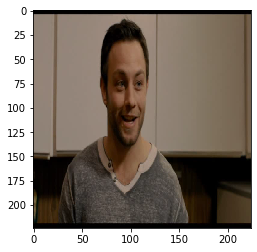

In [124]:
plt.imshow(X_training[1])
print(Y_training[1])

In [149]:
gen_aug = datagen.flow(X_training, Y_training, batch_size=5)

In [161]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    #axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

ValueError: could not broadcast input array from shape (5,224,224,3) into shape (5)

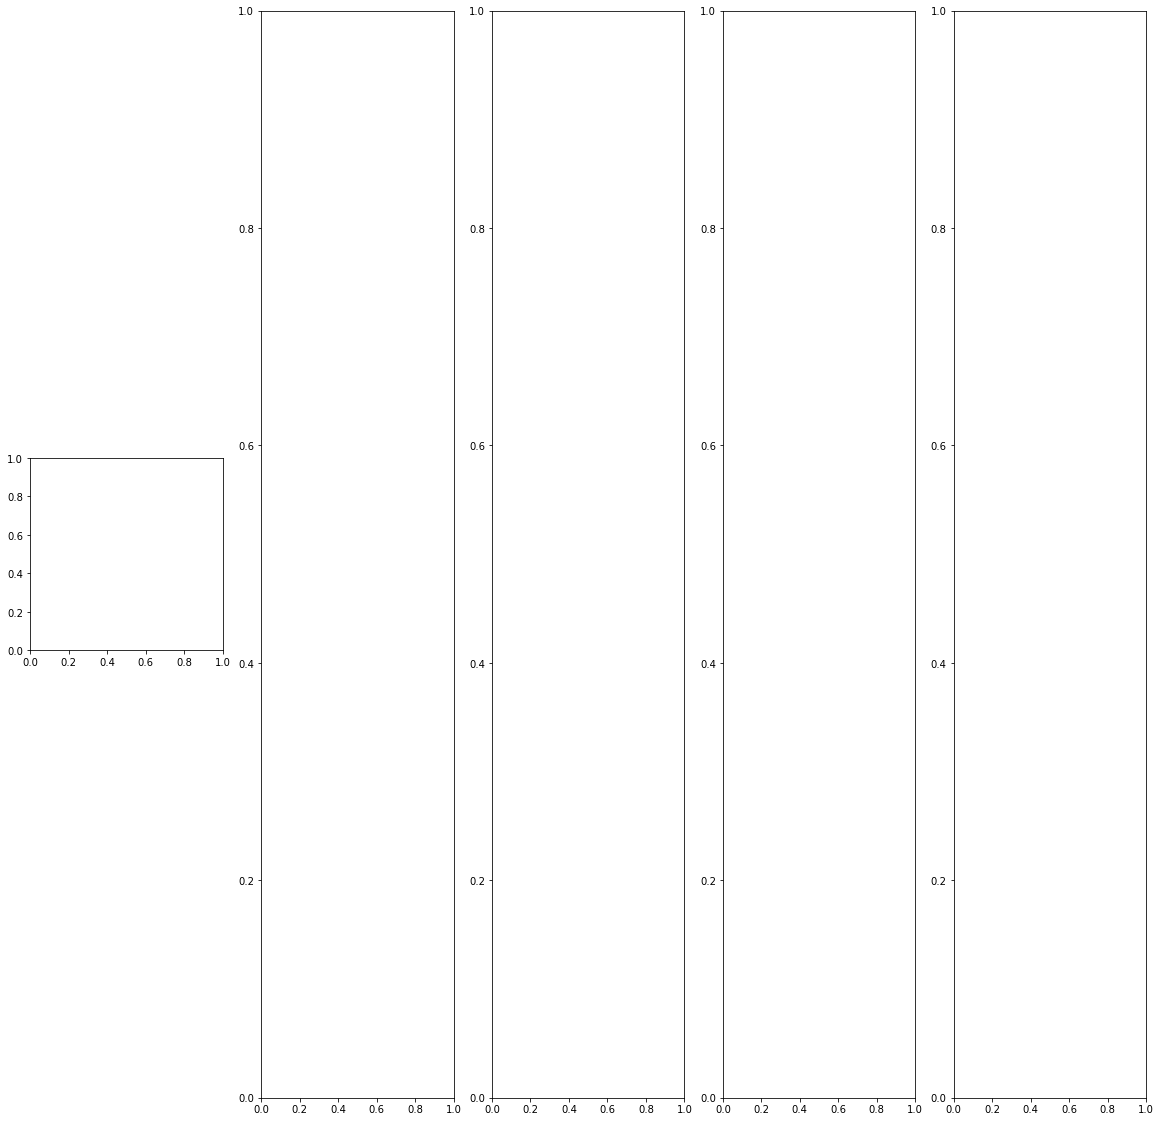

In [162]:
plotImages(gen_aug)